# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
medical = pd.read_csv('data/insurance2.csv')

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

In [4]:
from sklearn.utils import resample

charges = medical.charges
N_rep = 10000

seed(47)
ch_bs = np.array([resample(charges) for n in np.arange(N_rep)])
ch_bs_mean = np.mean(ch_bs, axis=1)
ch_bs_int = np.percentile(ch_bs_mean, 5)
print('95% Confidence Lower Charge Mean Interval: ${:,.2f}'.format(ch_bs_int))

95% Confidence Lower Charge Mean Interval: $12,724.47


If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value \\$12,724 here, which compares very well with the value \\$12,725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

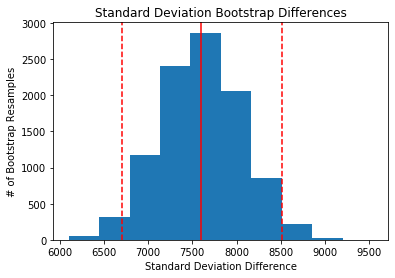

Insurance Std Difference Interval (95%): $6,708.70 - $8,513.29


In [5]:
ins_mask = medical.insuranceclaim == True
ins_yes = charges[ins_mask]
ins_no = charges[~ins_mask]

seed(47)
bs_yes = np.array([resample(ins_yes) for n in np.arange(N_rep)])
bs_yes_std = np.std(bs_yes, ddof=1, axis=1)
seed(47)
bs_no = np.array([resample(ins_no) for n in np.arange(N_rep)])
bs_no_std = np.std(bs_no, ddof=1, axis=1)

bs_std_diff = bs_yes_std - bs_no_std
bsd_mean = np.mean(bs_std_diff)
bsd_q = np.percentile(bs_std_diff, [2.5, 97.5])

plt.hist(bs_std_diff)
plt.title('Standard Deviation Bootstrap Differences')
plt.xlabel('Standard Deviation Difference')
plt.ylabel('# of Bootstrap Resamples')
plt.axvline(bsd_mean, color='r')
plt.axvline(bsd_q[0], color='r', linestyle='--')
plt.axvline(bsd_q[1], color='r', linestyle='--')
plt.show()

int_print = 'Insurance Std Difference Interval (95%): ${:,.2f} - ${:,.2f}'
print(int_print.format(bsd_q[0], bsd_q[1]))

**Standard Deviation Hypotheses**
\begin{equation}
H_0: std_{yes} = std_{no}, \\
H_a: std_{yes} \neq std_{no}
\end{equation}

>__A:__ In this case I would reject, with 95% confidence, the null hypothesis which predicts the standard deviations of both groups to be equal, because a standard deviation difference value of zero is not within the 95% confidence interval of the true standard deviation difference; we can say with 95% that the true populations' parameter difference lies somewhere between about \\$6,708.70 and \\$8,513.29. 

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

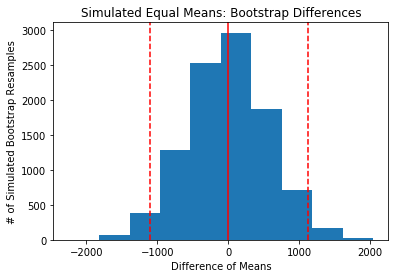

Simulated Mean Difference Interval (95%): -$1,100.12 to $1,127.02

Probability of Seeing an Absolute Difference of $7,602.51 or Greater: 0.0000000000000000%


In [6]:
obs_mean_diff = np.mean(ins_yes) - np.mean(ins_no)
bs_mean_yes = np.mean(bs_yes, axis=1)
bs_mean_no = np.mean(bs_no, axis=1)
bs_mean_diff = bs_mean_yes - bs_mean_no

bmd_mean = np.mean(bs_mean_diff)
bmd_std = np.std(bs_mean_diff)

sim_equal_mean = bs_mean_diff - bmd_mean
sim_mean = np.mean(sim_equal_mean)
sim_prob = np.sum(np.abs(sim_equal_mean) >= np.abs(obs_mean_diff)) / len(sim_equal_mean)
sim_q = np.percentile(sim_equal_mean, [2.5, 97.5])

plt.hist(sim_equal_mean)
plt.title('Simulated Equal Means: Bootstrap Differences')
plt.xlabel('Difference of Means')
plt.ylabel('# of Simulated Bootstrap Resamples')
plt.axvline(sim_mean, color='r')
plt.axvline(sim_q[0], color='r', linestyle='--')
plt.axvline(sim_q[1], color='r', linestyle='--')
plt.show()

mean_int_print = 'Simulated Mean Difference Interval (95%): -${:,.2f} to ${:,.2f}\n'
print(mean_int_print.format(np.abs(sim_q[0]), sim_q[1]))
mean_prob_print = "Probability of Seeing an Absolute Difference of ${:,.2f} or Greater: {:.16f}%"
print(mean_prob_print.format(obs_mean_diff, sim_prob*100))

**Mean Hypotheses**
\begin{equation}
H_0: u_{yes} = u_{no}, \\
H_a: u_{yes} \neq u_{no}
\end{equation}

>__A:__ After obtaining 10,000 bootstrap replicates of the difference in means for the two groups, we can reject with more than 99.99% confidence the null hypothesis which states both groups have an average charge equal to each other, because as it can be seen above, there were zero bootstrap resamples were a difference between the means of the charges was equal to or greater than the observed difference; the observed difference showed that the patients who claimed insurance were on average charged \\$7,602.51 more than those who did not. 

__Q:__ To put the above result into perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

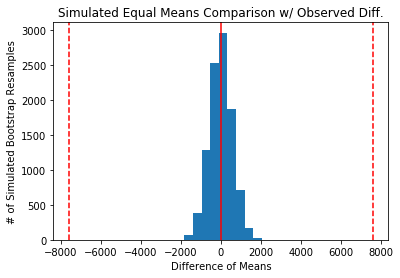

In [7]:
plt.hist(sim_equal_mean)
plt.title('Simulated Equal Means Comparison w/ Observed Diff.')
plt.xlabel('Difference of Means')
plt.ylabel('# of Simulated Bootstrap Resamples')
plt.axvline(sim_mean, color='r')
plt.axvline(obs_mean_diff, color='r', linestyle='--')
plt.axvline(-np.abs(obs_mean_diff), color='r', linestyle='--')
plt.show()

>__A:__ The reason why we plot more than one line is that the null hypothesis states the means to be equal, so in order to accept the null hypothesis we have to test both possibilities; we have to test that the insured patients do not get charged more than the uninsured patients on average, as well as that the insured patients are not getting charged less than the uninsured patients. The reason why we are challenging the null hypothesis is that we observed a difference of \\$7,602.51 in the average amount charged; when testing the null hypothesis, we will use the magnitude of observed difference to test the null hypothesis and the probability of seeing such difference if the mean difference was equal to zero. 

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

In [8]:
import scipy.stats as stats

t, prob_equal_mean = stats.ttest_ind(ins_no, ins_yes, equal_var=False) 
resamples_needed = 1 / prob_equal_mean
print('Number of Resamples Needed to Get 1 Occurence of Obs. Mean Difference: {:.1}'.format(resamples_needed))

Number of Resamples Needed to Get 1 Occurence of Obs. Mean Difference: 9e+36


>__A:__ The probability acquired in the previous assignment of about 1e-37 is essentially the same as the probability of zero we got from running 10,000 bootstrap resamples. We would need to run about 9e+36 bootstrap resamples given the frequentist probability of about 1e-37, before we got a difference as large as the one observed in the original sample data, and even then, there is no guarantee that we would observe such difference. Therefore, I would rather reject the null hypothesis than run 9e+36 bootstramp resamples without a guarantee of seeing such difference. 

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

>__A:__ Based on the results of the bootstrap test performed on the standard deviations of the two samples, we can conlude with a high level of confidence that the two groups do not have equal variances. Therefore, the correct approach to calculating the probability of the groups' means being equal to each other is the second, which assumed the groups' variances to be unequal. 

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

>__A:__ The whole point of trying to implement a new algorithm is to improve the success metric currently in place which in this case is click-through rate; therefore I would perform a one-sided test with the hypotheses as defined below: 
>
>\begin{equation}
H_0: p_{old} >= p_{new}, \\
H_a: p_{old} < p_{new}
\end{equation}
>
> The null hypothesis would be that the click-through rate, i.e. proportion, of the new algorithm is no better if not worse than the click-through proportion of the old algorithm; therefore, if we observe a higher click-through rate for the new algorithm than the old algorithm, the p-value we get from the one-sided test will tell us what the probability of the observed improvement occurring given the null hypothesis were to be true. If the resulting probability of the A/B test stated with 95% that the new algorithm's improvement in the click-through rate would not have happened, we can reject the null hypothesis; this means that there is still a 5% chance that the observed improvement is due to chance, and the new algorithm in fact performs the same as or worse than the old algorithm. If we incorrectly rejected the null hypothesis, we would replace the old algorithm with the new algorithm; this would cause the click-through rate of the ad-recommender to drop, or at best, the click-through rate would be the same as it was with the old algorithm.

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.